In [83]:
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('../data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {} # {language_name: [name, ...]}
all_categories = [] # [language_name, ...]

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print("num letters:", n_letters)
print("num categories:", n_categories)

['../data/names/Czech.txt', '../data/names/German.txt', '../data/names/Arabic.txt', '../data/names/Japanese.txt', '../data/names/Chinese.txt', '../data/names/Vietnamese.txt', '../data/names/Russian.txt', '../data/names/French.txt', '../data/names/Irish.txt', '../data/names/English.txt', '../data/names/Spanish.txt', '../data/names/Greek.txt', '../data/names/Italian.txt', '../data/names/Portuguese.txt', '../data/names/Scottish.txt', '../data/names/Dutch.txt', '../data/names/Korean.txt', '../data/names/Polish.txt']
num letters: 57
num categories: 18


In [84]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# 1-hot-encode a letter into a tensor <1 x n_letters> (just for demonstration)
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

# more clearly
for i in range(len('Jones')):
    print(f"i={i} [{'Jones'[i]}] - ", end=' ')
    for j in range(n_letters):
        content = str(lineToTensor('Jones')[i][0][j].item())
        content = content.replace('1.0', '\033[92m1\033[0m')
        content = content.replace('0.0', '0')
        print(content, end=' ')
    print()


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])
i=0 [J] -  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
i=1 [o] -  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
i=2 [n] -  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
i=3 [e] -  0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
i=4 [s] -  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 


In [85]:
import torch.nn as nn
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size, hidden_size) # input to hidden
        self.h2h = nn.Linear(hidden_size, hidden_size) # hidden to hidden
        self.h2o = nn.Linear(hidden_size, output_size) # hidden to output

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        hidden = F.tanh(self.i2h(input) + self.h2h(hidden)) # tanh(linear(input) + linear(hidden))
        
        output = self.h2o(hidden) # linear(hidden)
        output = self.softmax(output) # log_softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# input: <1 x n_letters>
# hidden: <1 x hidden_size>
# output: <1 x n_categories>
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


In [86]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden) # previous / initial hidden state

output, next_hidden = rnn(input[0], hidden) # run for 'A' in 'Albert'
print(output, next_hidden)

# shape of output: <1 x n_categories> -> probability of each category
print(output.size())

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

tensor([[-2.8868, -3.0004, -2.9989, -2.8315, -3.0157, -2.9973, -2.7225, -2.9091,
         -2.7888, -2.8437, -2.8608, -2.8242, -2.8165, -3.0044, -2.8514, -2.9587,
         -2.8345, -2.9475]], grad_fn=<LogSoftmaxBackward0>) tensor([[ 1.6140e-01, -7.0504e-02,  1.4925e-01, -6.1425e-02,  7.3828e-02,
         -2.0437e-01, -2.1619e-01,  1.4293e-01, -1.9082e-01,  4.5574e-02,
         -2.0209e-02, -4.5056e-02, -1.1635e-02,  1.9511e-01, -2.5615e-01,
          6.7848e-02,  1.5388e-01, -2.1387e-01, -6.3830e-02,  1.0212e-01,
         -6.7949e-02, -1.9721e-01, -8.0653e-02,  1.4516e-01, -6.3585e-02,
         -2.5449e-02,  1.9069e-01, -8.5875e-02, -6.9747e-02,  8.0546e-02,
         -1.9401e-02,  2.4366e-02,  9.2743e-04,  1.2489e-03,  1.0813e-01,
          5.5798e-02,  2.1819e-01,  5.2703e-02,  1.1998e-01, -5.5690e-02,
          2.2754e-02,  3.1801e-02, -4.2291e-02,  6.8035e-02, -1.0539e-01,
          2.7584e-01,  9.5830e-02, -1.0208e-01, -2.0887e-02,  1.4675e-01,
          8.5051e-02,  1.1229e-01, -9.

In [87]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '| line =', line)


category = Russian | line = Oborotov
category = Arabic | line = Qureshi
category = Russian | line = Glazunov
category = Korean | line = Yi
category = Irish | line = Sioda
category = Portuguese | line = Henriques
category = Korean | line = Tsai 
category = Czech | line = Skeril
category = Vietnamese | line = Quang
category = Greek | line = Geracimos


In [88]:
criterion = nn.NLLLoss() # negative log likelihood loss - since the last layer is log_softmax

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate) # type: ignore

    return output, loss.item()


In [89]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s | %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 2s) 2.4375 Biondi | Japanese ✗ (Italian)
10000 10% (0m 4s) 2.2801 Lieu | German ✗ (Vietnamese)
15000 15% (0m 7s) 2.9568 Nussbaum | Arabic ✗ (German)
20000 20% (0m 9s) 1.2087 Lesauvage | French ✓
25000 25% (0m 11s) 3.0054 Deeb | Dutch ✗ (Arabic)
30000 30% (0m 14s) 1.2384 Buchholz | German ✓
35000 35% (0m 16s) 1.9348 Jarzembowski | Polish ✗ (Czech)
40000 40% (0m 18s) 1.6917 Ochiai | Italian ✗ (Japanese)
45000 45% (0m 21s) 1.2392 Nowak | Polish ✗ (Czech)
50000 50% (0m 23s) 0.7847 Basurto | Portuguese ✓
55000 55% (0m 25s) 1.7684 Vernon | French ✗ (English)
60000 60% (0m 28s) 0.0968 Ribeiro | Portuguese ✓
65000 65% (0m 30s) 0.3731 Schroeder | German ✓
70000 70% (0m 32s) 1.1404 Eslick | English ✓
75000 75% (0m 35s) 0.0037 Horoshavtsev | Russian ✓
80000 80% (0m 37s) 0.3869 Kosmatka | Polish ✓
85000 85% (0m 40s) 0.4911 Mochan | Irish ✓
90000 90% (0m 42s) 0.1789 Ganim | Arabic ✓
95000 95% (0m 45s) 0.8895 Davison | English ✓
100000 100% (0m 47s) 0.5325 Watt | Scottish ✓


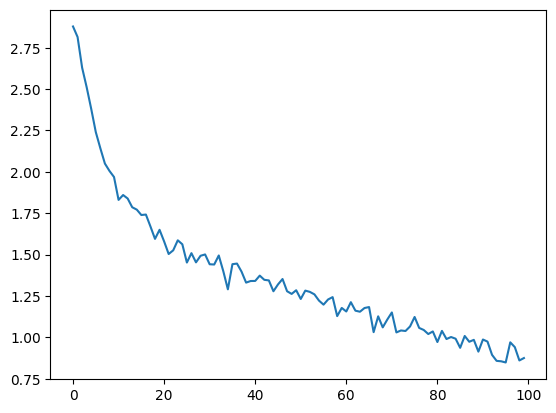

In [91]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


/var/folders/g6/xn7nvvtn4ng5pf9bhxfs7p2m0000gn/T/ipykernel_49877/3649271960.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/g6/xn7nvvtn4ng5pf9bhxfs7p2m0000gn/T/ipykernel_49877/3649271960.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


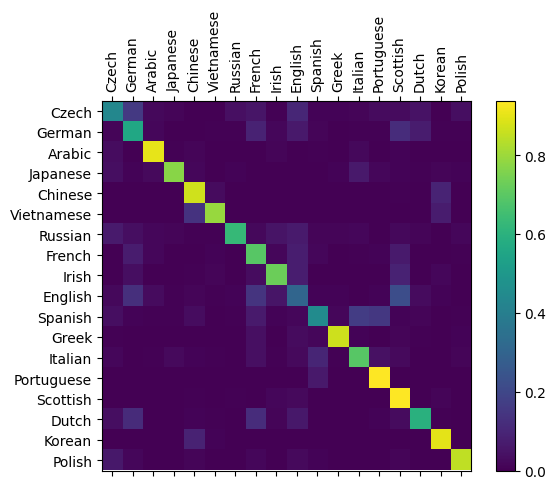

In [92]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()


In [93]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')



> Dovesky
(-0.39) Czech
(-1.50) English
(-3.20) Russian

> Jackson
(-0.05) Scottish
(-3.29) English
(-4.72) Russian

> Satoshi
(-0.33) Polish
(-2.02) Japanese
(-3.15) Greek
